In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder, Imputer
from sklearn.metrics import accuracy_score
import xgboost as xgb

from sklearn.datasets import load_breast_cancer
# from imblearn.over_sampling import SMOTE, RandomOverSampler

In [5]:
GOAL = ['target']
FEATURES = ['mean radius', 'mean texture', 'mean perimeter', 'mean area',
           'mean smoothness', 'mean compactness', 'mean concavity',
           'mean concave points', 'mean symmetry', 'mean fractal dimension',
           'radius error', 'texture error', 'perimeter error', 'area error',
           'smoothness error', 'compactness error', 'concavity error',
           'concave points error', 'symmetry error', 'fractal dimension error',
           'worst radius', 'worst texture', 'worst perimeter', 'worst area',
           'worst smoothness', 'worst compactness', 'worst concavity',
           'worst concave points', 'worst symmetry', 'worst fractal dimension'
           ]
IGNORED_FEATURES = [] # a placeholder for irrelevant features
TRAIN_FEATURES = list(set([c for c in FEATURES if c not in IGNORED_FEATURES]))
CATEGORICAL_FEATURES = [] # features that require pre-processing

over_sampling = False

In [6]:
def run_load_data():
    print ('load_data - START')
    breast_cancer = load_breast_cancer()
    data = pd.DataFrame(data= np.c_[breast_cancer['data'], \
                                     breast_cancer['target']],
                        columns= ['mean radius', 'mean texture', 'mean perimeter', 'mean area',
                               'mean smoothness', 'mean compactness', 'mean concavity',
                               'mean concave points', 'mean symmetry', 'mean fractal dimension',
                               'radius error', 'texture error', 'perimeter error', 'area error',
                               'smoothness error', 'compactness error', 'concavity error',
                               'concave points error', 'symmetry error', 'fractal dimension error',
                               'worst radius', 'worst texture', 'worst perimeter', 'worst area',
                               'worst smoothness', 'worst compactness', 'worst concavity',
                               'worst concave points', 'worst symmetry', 'worst fractal dimension', 
                                'target'] 
                        )
    
    print ('load_data - END')
    return data

In [7]:
def run_train_test_split(data):
    print ('train_test_split - START')
    train_df, test_df = train_test_split(data, test_size=0.2, random_state=42)
    print ('train_test_split - END')
    return train_df, test_df

In [8]:
def run_pre_processing(train_df, test_df):
    print ('pre_processing - START')  
    # Fill NULL with Mean / Median / -1
    for f in FEATURES:
        imp = Imputer(missing_values='NaN', strategy='median',axis=0, copy=False)
        train_df[f] = imp.fit_transform(train_df[f].reshape(-1,1))
        test_df[f] = imp.fit_transform(test_df[f].reshape(-1,1))
    
    # Pre-processing non-numeric values using numeric encoding
    # Why use numeric encoding over one hot encoding:
    # https://medium.com/data-design/visiting-categorical-features-and-encoding-in-decision-trees-53400fa65931
    # Encode using .cat.codes or LabelEncoder:
    # http://pbpython.com/categorical-encoding.html
    for f in CATEGORICAL_FEATURES:
        train_df[f] = train_df[f].astype('category').cat.codes
        test_df[f] = test_df[f].astype('category').cat.codes
#         lbl = LabelEncoder()
#         train_df[f] = lbl.fit_transform(train_df[f].reshape(-1,1))
#         test_df[f] = lbl.fit_transform(test_df[f].reshape(-1,1))
    print ('pre_processing - END') 
    return train_df, test_df

In [9]:
def run_x_y_split(train_df, test_df):
    print ('x_y_split - START')
    X_train = train_df[TRAIN_FEATURES]
    y_train = train_df[GOAL]
    X_test = test_df[TRAIN_FEATURES]
    y_test = test_df[GOAL]
    print ('x_y_split - END')
    return X_train, y_train, X_test, y_test

In [10]:
def run_over_sampling(X_train, y_train):
    print ('over_sampling - START')
#     TODO: Figure how to oversample using SMOTE 
#     X_train, y_train = SMOTE().fit_sample(X_train, y_train)
#     X_train, y_train = RandomOverSampler().fit_sample(X_train, y_train)
    print ('over_sampling - END')
    return X_train, y_train

In [27]:
def run_grid_search(X_train, y_train):
    print ('grid_search - START')
    dmatrix = xgb.DMatrix(data=X_train, label=y_train)
    gbm_param_grid = {
        'learning_rate': [0.1, 0.05],
        'max_depth': [3, 4],
        'n_estimators': [500, 750],
        'subsample': [0.5, 0.75],
        'colsample_bytree': [0.5, 0.75]
    }
    
    gbm = xgb.XGBClassifier()
    
    # Perform grid search
    grid = GridSearchCV(estimator=gbm, param_grid=gbm_param_grid,
                            scoring='roc_auc', cv=5, verbose=1)
    grid.fit(X_train, y_train.values.ravel()) # Using values.ravel() to change to 1D array - https://stackoverflow.com/questions/42928855/gridsearchcv-error-too-many-indices-in-the-array

    # Print the best parameters & metric
    print("Best parameters found: ", grid.best_params_)
    print("Best AUC found: ", grid.best_score_)
    
    best_learning_rate = grid.best_params_["learning_rate"]
    best_max_depth = grid.best_params_["max_depth"]
    best_n_estimators = grid.best_params_["n_estimators"]    
    best_sub_sample = grid.best_params_["subsample"]   
    best_colsample_bytree = grid.best_params_["colsample_bytree"]  
    
    print ('grid_search - END')    
    return best_learning_rate, best_max_depth, best_n_estimators, best_sub_sample, best_colsample_bytree

In [25]:
def run_cross_validation(X_train, y_train, best_learning_rate, best_max_depth, best_n_estimators, best_sub_sample, best_colsample_bytree):
    print ('cross_validation - START')
    dmatrix = xgb.DMatrix(data=X_train, label=y_train)
    params = {"objective":"binary:logistic", 
              "learning_rate":best_learning_rate,
              "max_depth":best_max_depth,
              "n_estimators":best_n_estimators,
              "subsample":best_sub_sample,
              "colsample_bytree":best_colsample_bytree
             }
    
    print(dmatrix)
    
    cv_results = xgb.cv(dtrain=dmatrix,
                        params=params,
                        nfold=5,
                        stratified=True,
                        num_boost_round=10,
                        metrics="auc",
                        as_pandas=True,
                        seed=123)
    print(cv_results)
    model_evaluation_metric = cv_results["test-auc-mean"].iloc[-1]
    print "cross-validation model accuracy on train dataset: ", model_evaluation_metric
    print ('cross_validation - END')    

In [13]:
def run_train_model(X_train, y_train, best_learning_rate, best_max_depth, best_n_estimators, best_sub_sample, best_colsample_bytree):
    print ('train_model - START')    
    model = xgb.XGBClassifier(objective='binary:logistic',
                              learning_rate=best_learning_rate,
                              max_depth=best_max_depth,
                              n_estimators=best_n_estimators,
                              subsample=best_sub_sample,
                              colsample_bytree=best_colsample_bytree,
                              silent=True,
                              seed=123
                             )
    
    model.fit(X_train, y_train)
    print ('train_model - END')   
    return model

In [14]:
def run_prediction(model, X_test):
    print ('run_prediction - START')  
    prediction = model.predict(data=X_test)
    print ('run_prediction - END')  
    return prediction

In [15]:
def run_model_evaluation_on_test(prediction, y_test):
    print ('model_evaluation_on_test - START') 
    prediction = pd.DataFrame(data = prediction, index=y_test.index, columns = ['target'])
    model_evaluation_metric = accuracy_score(y_test, prediction)
    print "model accuracy on test dataset: ", model_evaluation_metric
    print ('model_evaluation_on_test - END')

In [16]:
def run_feature_importance(model):
    print ('feature_importance - START') 
    xgb.plot_importance(booster=model)
    plt.title('Feature Importance')
    plt.xlabel('Relative Importance')
    plt.ylabel('Features')
    plt.tight_layout()
    plt.show()
    print ('feature_importance - END')   

load_data - START
load_data - END
train_test_split - START
train_test_split - END
pre_processing - START


/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:6: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


pre_processing - END
x_y_split - START
x_y_split - END
grid_search - START
Fitting 5 folds for each of 32 candidates, totalling 160 fits


/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:7: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  import sys
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:  1.0min finished


('Best parameters found: ', {'n_estimators': 750, 'subsample': 0.75, 'learning_rate': 0.1, 'colsample_bytree': 0.75, 'max_depth': 4})
('Best AUC found: ', 0.99337765895895491)
grid_search - END
train_model - START
train_model - END
run_prediction - START
run_prediction - END
model_evaluation_on_test - START
model accuracy on test dataset:  0.973684210526
model_evaluation_on_test - END
feature_importance - START


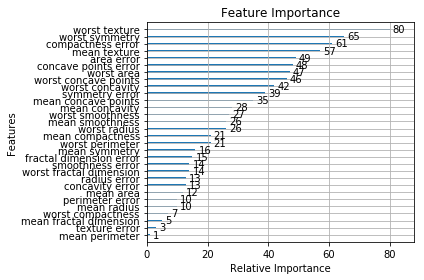

feature_importance - END
('elapsed_time (in seconds): ', 65.89045000076294)


In [28]:
def xgboost_binary_classification():
    start_time = time.time()
    data = run_load_data()
    train_df, test_df = run_train_test_split(data) # Don't have to run this if you given data is already splitted into train & test
    train_df, test_df = run_pre_processing(train_df, test_df)
    X_train, y_train, X_test, y_test = run_x_y_split(train_df, test_df)
    if over_sampling:
        X_train, y_train = run_over_sampling(X_train, y_train)
    best_learning_rate, best_max_depth, best_n_estimators, best_sub_sample, best_colsample_bytree = run_grid_search(X_train, y_train)
# To check accuracy, run either Grid Search or Cross Validation as Cross Validation is already embedded in Grid Search
#     run_cross_validation(X_train, y_train, best_learning_rate, best_max_depth, best_n_estimators, best_sub_sample, best_colsample_bytree)
    model = run_train_model(X_train, y_train, best_learning_rate, best_max_depth, best_n_estimators, best_sub_sample, best_colsample_bytree)
    prediction = run_prediction(model, X_test)
    run_model_evaluation_on_test(prediction, y_test)
    run_feature_importance(model)
    print('elapsed_time (in seconds): ', time.time() - start_time)
xgboost_binary_classification()